#############################
# Diabete Feature Engineering
##############################

# Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
# istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
           # Adım 1: Genel resmi inceleyiniz.
           # Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
           # Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.
           # Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
           # Adım 5: Aykırı gözlem analizi yapınız.
           # Adım 6: Eksik gözlem analizi yapınız.
           # Adım 7: Korelasyon analizi yapınız.

# GÖREV 2: FEATURE ENGINEERING
           # Adım 1:  Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb.
           # değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri
           # 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere
           # işlemleri uygulayabilirsiniz.
           # Adım 2: Yeni değişkenler oluşturunuz.
           # Adım 3:  Encoding işlemlerini gerçekleştiriniz.
           # Adım 4: Numerik değişkenler için standartlaştırma yapınız.
           # Adım 5: Model oluşturunuz.


In [1]:

# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


df = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


##################################
# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
##################################

##################################
# GENEL RESİM
##################################

In [2]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

df.head()
df.info()

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

##################################
# NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI
##################################


In [3]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols
num_cols
cat_but_car

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


[]


##################################
# KATEGORİK DEĞİŞKENLERİN ANALİZİ
##################################


In [4]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

cat_summary(df, "Outcome")


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################



##################################
# NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ
##################################


In [5]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)


         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067





##################################
# KORELASYON
##################################

# Korelasyon, olasılık kuramı ve istatistikte iki rassal değişken arasındaki doğrusal ilişkinin yönünü ve gücünü belirtir


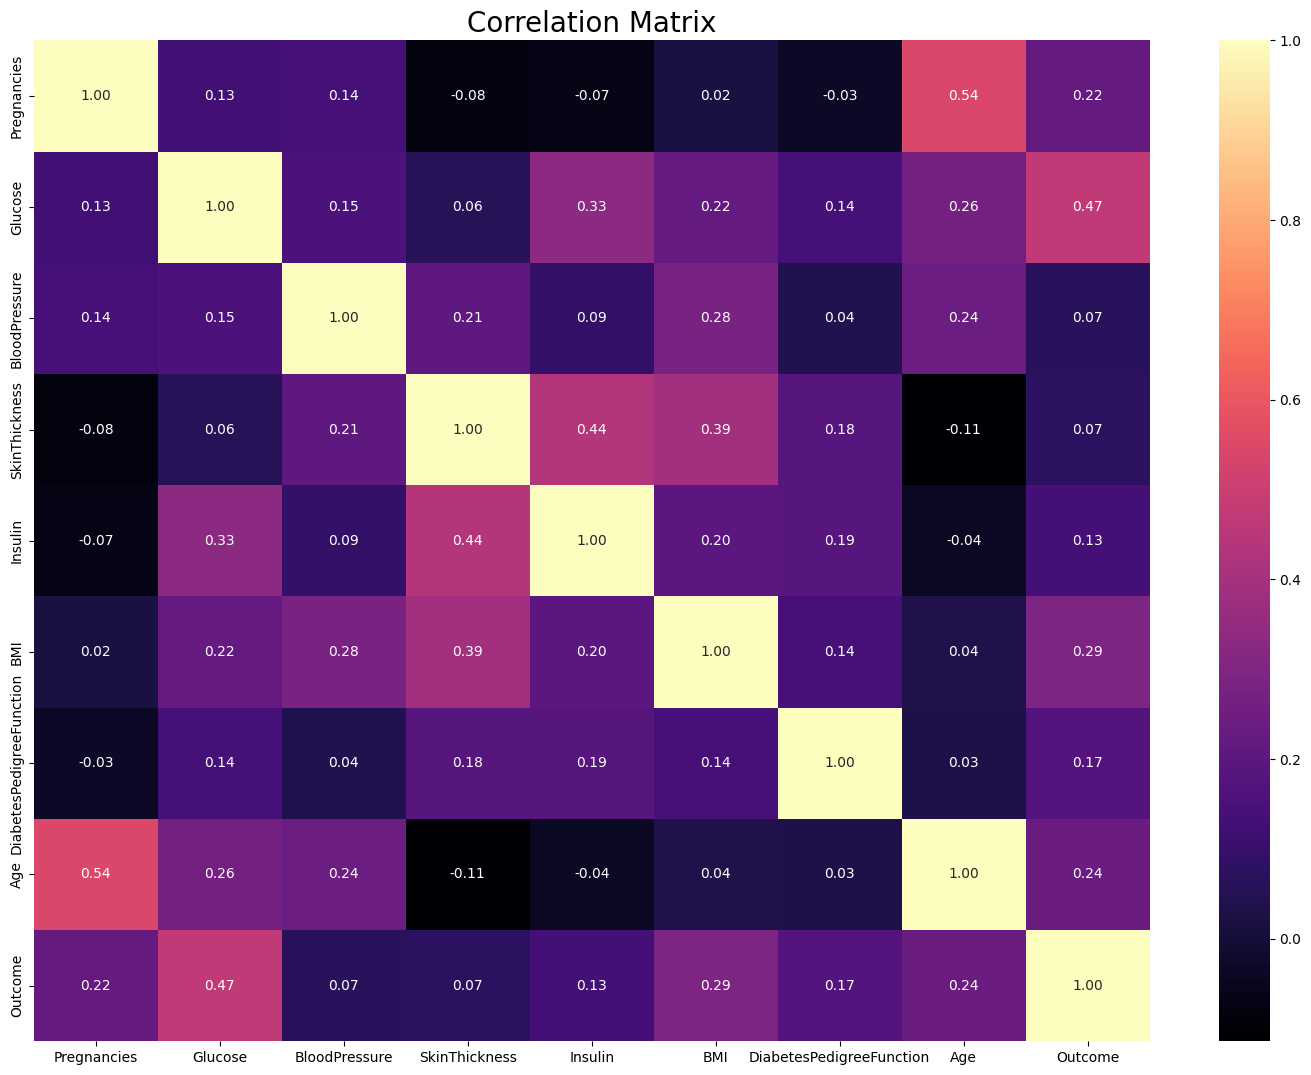

In [6]:
df.corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()



##################################
# GÖREV 2: FEATURE ENGINEERING
##################################

##################################
# EKSİK DEĞER ANALİZİ
##################################

In [7]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
# Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

# Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [8]:

# Eksik Gözlem Analizi
df.isnull().sum()

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['eksikdeğer', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               eksikdeğer  ratio
Insulin               374 48.700
SkinThickness         227 29.560
BloodPressure          35  4.560
BMI                    11  1.430
Glucose                 5  0.650


In [9]:
# Eksik Değerlerin Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB



##################################
# AYKIRI DEĞER ANALİZİ
##################################

In [11]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



In [12]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
print("################################################")
for col in df.columns:
    print(col, check_outlier(df, col))



Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
################################################
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


##################################
# ÖZELLİK ÇIKARIMI
##################################


In [14]:

# Yaş grubunu belirleme fonksiyonu

df['age_group'] = pd.cut(df['Age'], bins=[0, 14,65,100], labels=['Çocuk', 'Çalışan Nüfus', 'Yaşlı'])
df.groupby("age_group")["Outcome"].mean()



# BMI'ye göre kategoriler oluşturma
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Zayıf', 'Normal', 'Fazla Kilolu', 'Obesite'])
df.groupby("BMI_Category")["Outcome"].mean()

# Gebelik sayısına göre kategoriler oluşturma
df['Pregnancy_Category'] = pd.cut(df['Pregnancies'], 
                                  bins=[0, 1, 3, 6, np.inf], 
                                  labels=['0', '1-3', '4-6', '7+'], 
                                  right=False)  

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Çalışan Nüfus,Obesite,7+
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Çalışan Nüfus,Fazla Kilolu,1-3
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Çalışan Nüfus,Normal,7+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Çalışan Nüfus,Fazla Kilolu,1-3
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Çalışan Nüfus,Obesite,0



##################################
# ENCODING
##################################

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 12
cat_cols: 4
num_cols: 8
cat_but_car: 0
num_but_cat: 4


In [16]:
# 2 değişkeni olankalr için uygulanır.
def label_encoder(dataframe, binary_cols):
    labelencoder = LabelEncoder()
    for binary_col in binary_cols:
        dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtype != [[int, float]]
               and df[col].nunique() == 2]
label_encoder(df,binary_cols)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obesite,7+
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,1,Fazla Kilolu,1-3
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1,Normal,7+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,Fazla Kilolu,1-3
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,Obesite,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    float64 
 3   SkinThickness             768 non-null    float64 
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    int64   
 9   age_group                 768 non-null    int64   
 10  BMI_Category              768 non-null    category
 11  Pregnancy_Category        768 non-null    category
dtypes: category(2), float64(6), int64(4)
memory usage: 62.0 KB


In [18]:
# 2'den fazla değişken mevcut fakat aralarında bir üstünlük mevcut. Hamilelik sayısısı arttıkça diabet olma riskide artmaktadır.
le=LabelEncoder()
df["Pregnancy_Category"]=le.fit_transform(df["Pregnancy_Category"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obesite,3
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,1,Fazla Kilolu,1
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1,Normal,3
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,Fazla Kilolu,1
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,Obesite,0


In [19]:
# 2'den fazla değişken var ve aralarında bir üstünlük olmadığı için one hot encoding işlemi yapılır.

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, ["BMI_Category"], drop_first=True)


df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,Pregnancy_Category,BMI_Category_Normal,BMI_Category_Fazla Kilolu,BMI_Category_Obesite
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,3,False,False,True
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,1,1,False,True,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1,3,True,False,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,1,False,True,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,0,False,False,True


##################################
# STANDARTLAŞTIRMA
##################################

In [20]:
num_cols

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])



In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pregnancies                768 non-null    float64
 1   Glucose                    768 non-null    float64
 2   BloodPressure              768 non-null    float64
 3   SkinThickness              768 non-null    float64
 4   Insulin                    768 non-null    float64
 5   BMI                        768 non-null    float64
 6   DiabetesPedigreeFunction   768 non-null    float64
 7   Age                        768 non-null    float64
 8   Outcome                    768 non-null    int64  
 9   age_group                  768 non-null    int64  
 10  Pregnancy_Category         768 non-null    int64  
 11  BMI_Category_Normal        768 non-null    bool   
 12  BMI_Category_Fazla Kilolu  768 non-null    bool   
 13  BMI_Category_Obesite       768 non-null    bool   

In [22]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,Pregnancy_Category,BMI_Category_Normal,BMI_Category_Fazla Kilolu,BMI_Category_Obesite
0,0.353,0.671,0.490,0.344,0.172,0.315,0.234,0.483,1,1,3,False,False,True
1,0.059,0.265,0.429,0.270,0.172,0.172,0.117,0.167,0,1,1,False,True,False
2,0.471,0.897,0.408,0.270,0.172,0.104,0.254,0.183,1,1,3,True,False,False
3,0.059,0.290,0.429,0.196,0.124,0.202,0.038,0.000,0,1,1,False,True,False
4,0.000,0.600,0.163,0.344,0.239,0.509,0.944,0.200,1,1,0,False,False,True


12-Model Oluşturma

In [23]:

df=df.drop(columns=["Age","BMI","Pregnancies"])
y_train=df["Outcome"]
x_train=df.drop(["Outcome"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30,random_state=42)

from sklearn.ensemble import RandomForestClassifier


# Random Forest modelini oluştur ve eğit
rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = rf_model.predict(X_test)



print(f"Accuracy: {(accuracy_score(y_pred, y_test))}")



Accuracy: 0.7359307359307359



##################################
# FEATURE IMPORTANCE
##################################



   Value                    Feature
0  0.347                    Glucose
4  0.166   DiabetesPedigreeFunction
3  0.122                    Insulin
1  0.114              BloodPressure
2  0.101              SkinThickness
6  0.054         Pregnancy_Category
9  0.053       BMI_Category_Obesite
7  0.020        BMI_Category_Normal
8  0.017  BMI_Category_Fazla Kilolu
5  0.006                  age_group


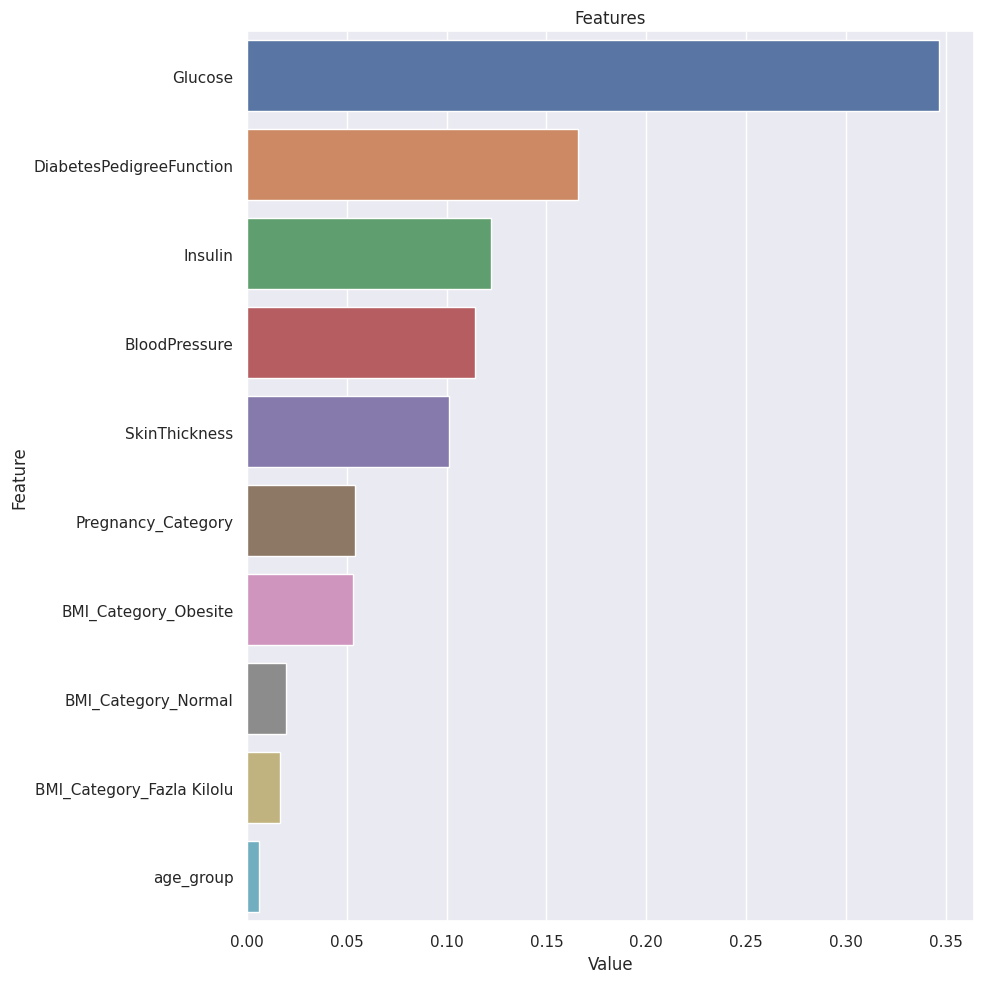

In [24]:
def plot_importance(model, features, num=len(X_train), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X_train)